In [745]:
import yfinance as yf
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import datetime
import cvxpy as cp

In [773]:
corn_df = pd.read_csv('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/Corn Price.csv')
cotton_df = pd.read_csv('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/cotton3.csv')
cotton_df["Date"] = pd.to_datetime(cotton_df["Date"], dayfirst=True)
#cotton3 = cotton3.sort_values(by="Date")

#cotton3 = cotton3.reindex(index=cotton3.index[::-1])
wheat_df = pd.read_csv('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/wheat prices.csv')
soybean_df = pd.read_csv('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/Soybean Price.csv')





In [747]:
colour1 = '#BA6926'
colour2 = '#FFC43D'
colour3 = '#758E4F'
colour4 = '#84ACCE'

In [748]:
#change inputs to start and end as years??? manually calc num_years
#decrease time used to calc averages, use more recent data
def Mold(df, start, end, commodity):
    #change date from string to Datetime type
    df["Date"] = pd.to_datetime(df["Date"])
    
    num_years = end - start + 1
    
    #isolate data from 2000 to a given year 
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    df_train = df.loc[(df['Date'] >= start_date) & (df['Date'] < end_date)]
    
    
    #create arrays with month and year of each 
    years = np.ones(len(df_train["Date"]))
    months = np.ones(len(df_train["Date"]))
    
    
    count = np.zeros([num_years, 12])
    sums = np.zeros([num_years, 12])
    for i in range(len(df_train["Date"])):
        months[i] = df_train["Date"].iat[i].month
        years[i] = df_train["Date"].iat[i].year
    df_train["year"] = years
    df_train["month"] = months
    #print("dataframe of training data")
    #print(df_train[['Date', 'year', 'month', 'Close']])
    
    
    for i in range(len(df_train["Date"])): 
        sums[int(df_train["year"].iat[i]) - start, int(df_train["month"].iat[i]) - 1] += df_train["Close"].iat[i]
        count[int(df_train["year"].iat[i]) - start, int(df_train["month"].iat[i]) - 1] += 1
    
    #take average for each month over the years
    averages = np.mean(sums / count, axis = 0)
    
    
    
    #find average change as a percentage from month to month
    changes = sums / count
    steps = np.zeros([num_years, 12]) #as will have to go to next row (year) for the next change and last will be empty
    for i in range(num_years):
        for j in range(11):
            steps[i,j] = (changes[i, j+1] - changes[i, j]) / changes[i, j]
    #last column calc
    for i in range(num_years - 1):
        steps[i, 11] = (changes[i+1, 0] - changes[i, 11]) / changes[i, 11]
    steps[num_years -1, 11] = np.mean(steps[0:10, 11])
    av_steps = np.mean(steps, axis = 0)
    #print("average steps month to month is")
   # print(av_steps.round(2))
    
    
    return averages, df_train[['Date', 'year', 'month', 'Close']], av_steps
    
    
corn_avs, df_corn, av_steps_corn = Mold(corn_df, 2005, 2009, "Corn")
cotton_avs, df_cotton, av_steps_cotton = Mold(cotton_df, 2005, 2009, "Cotton")
wheat_avs, df_wheat, av_steps_wheat = Mold(wheat_df, 2005, 2009, "Wheat")
soybean_avs, df_soybean, av_steps_soybeans = Mold(soybean_df, 2005, 2009, "Soybean")


<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

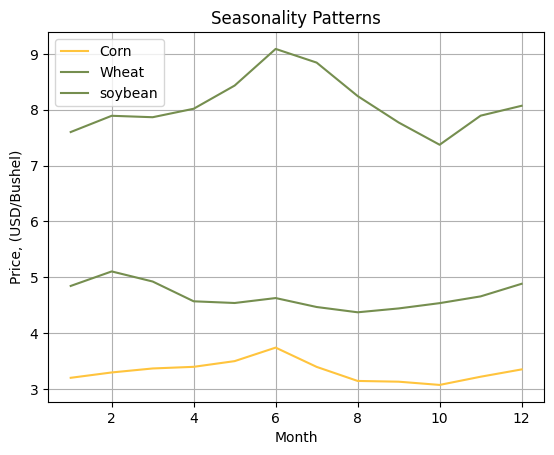

In [749]:
f = plt.figure(1)
x = np.linspace(1,12, 12)
plt.plot(x, corn_avs, c=colour2, label="Corn")
plt.plot(x, wheat_avs, c=colour3, label="Wheat")
plt.plot(x, soybean_avs, c=colour3, label="soybean")
#plt.plot(x, cotton_avs, c='g', label="Cotton")
plt.legend()
plt.grid()
plt.xlabel("Month")
plt.ylabel("Price, (USD/Bushel)")
plt.title("Seasonality Patterns")
f.show

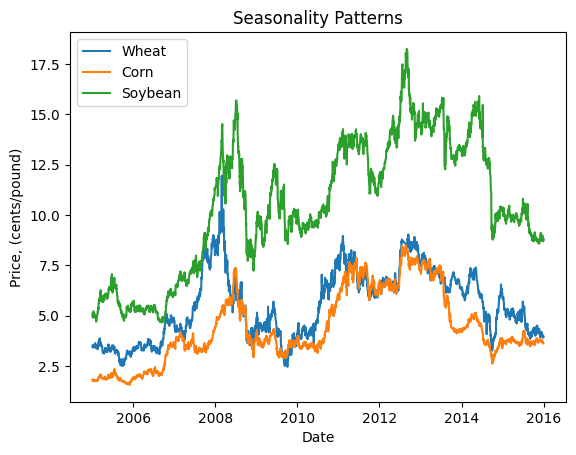

In [844]:
def five_year_trend(df, start_date, end_date, commodity):
    df = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    #print(df.head())
    
    
    f = plt.figure(1)
    x = np.linspace(1,12, 12)
    plt.plot(df['Date'], df['Close'], label=commodity)
    plt.xlabel("Date")
    plt.ylabel("Price, (cents/pound)")
    plt.title("Seasonality Patterns")
    plt.legend()
    plt.savefig('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/spots2.png')
    f.show
five_year_trend(wheat_df, '2005-01-01', '2015-12-31', 'Wheat')
five_year_trend(corn_df, '2005-01-01', '2015-12-31', 'Corn')
five_year_trend(soybean_df, '2005-01-01', '2015-12-31', 'Soybean')
#five_year_trend(cotton_df, '2005-01-01', '2014-12-31', 'Cotton')

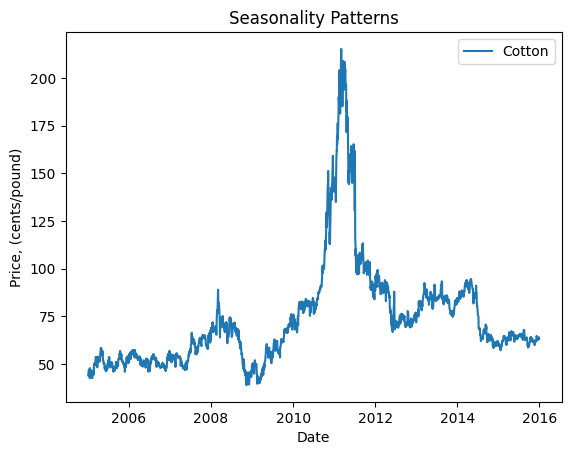

In [845]:
five_year_trend(cotton_df, '2005-01-01', '2015-12-31', 'Cotton')

In [752]:
#Trinomial Model Base
#n is number of time periods, p is prob of going up, q prob of going down

def generate_probs(n, p, q):
    n = n+1
    height = n * 2 + 1
    probs = np.zeros([height, n])
    #print(probs.shape)
    probs[int((height -1)/2), 0] = 1
    
    for i in range(n -1):
        for j in range(height - 2):
            probs[j +1, i + 1] = probs[j +1, i + 1] + (1 - p - q)*probs[j +1, i] + p*probs[j-1 +1, i] +q*probs[j+1+1, i]
    #print(probs.round(4))
    #returns matrix of probabilities, time evolving to the right, row is ranked worst to best outcome
    return probs[1:height-1, 0:n]
        
        
print(generate_probs(7, 0.6, 0).round(1)) 

[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.4 0.2 0.1 0.  0.  0.  0. ]
 [0.  0.6 0.5 0.3 0.2 0.1 0.  0. ]
 [0.  0.  0.4 0.4 0.3 0.2 0.1 0.1]
 [0.  0.  0.  0.2 0.3 0.3 0.3 0.2]
 [0.  0.  0.  0.  0.1 0.3 0.3 0.3]
 [0.  0.  0.  0.  0.  0.1 0.2 0.3]
 [0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]


In [753]:
#start is an indicator for what month the given starting price is in, e.g. if Feb, start = 2
#n is number of time periods (months) that model needs to extend to
def generate_price_evolution(avs, n, start, price, u):
    n = n+1
    height = n * 2 + 1
    matrix = np.zeros([height, n])
    #print(matrix.shape)
    matrix[int((height -1)/2), 0] = price
    for i in range(n -1):
        for j in range(height - 2):
            if matrix[j +1, i + 1] == 0:
                matrix[j +1, i + 1] = u*matrix[j, i] * (avs[(start -1 + i) % len(avs)] +1)
            if matrix[j +1, i + 1] == 0:
                matrix[j +1, i + 1] = matrix[j+1, i] * (avs[(start -1 + i) % len(avs)] +1)
            if matrix[j +1, i + 1] == 0:
                matrix[j +1, i + 1] = (matrix[j+2, i]/u) * (avs[(start -1 + i) % len(avs)] +1)
    #print(avs.round(3))
    return matrix[1:height-1, 0:n]
print(generate_price_evolution(av_steps_corn, 5, 7, 1, 1).round(3))
   

[[0.    0.    0.    0.    0.    1.054]
 [0.    0.    0.    0.    1.005 1.054]
 [0.    0.    0.    0.96  1.005 1.054]
 [0.    0.    0.933 0.96  1.005 1.054]
 [0.    0.938 0.933 0.96  1.005 1.054]
 [1.    0.938 0.933 0.96  1.005 1.054]
 [0.    0.938 0.933 0.96  1.005 1.054]
 [0.    0.    0.933 0.96  1.005 1.054]
 [0.    0.    0.    0.96  1.005 1.054]
 [0.    0.    0.    0.    1.005 1.054]
 [0.    0.    0.    0.    0.    1.054]]


In [754]:
#start is an indicator for what month the given starting price is in, e.g. if FEb, start = 2
#n is number of time periods (months) that model needs to extend to
def mean_reverting_price_evolution(LRM, scale, n, price, u):
    n = n+1
    height = n * 2 + 1
    matrix = np.zeros([height, n])
    #print(matrix.shape)
    matrix[int((height -1)/2), 0] = price
    for i in range(n -1):
        for j in range(height - 2):
            #if matrix[j +1, i + 1] == 0:
                #matrix[j +1, i + 1] = u*matrix[j, i] + scale * (LRM -   matrix[j +1, i + 1])
            #if matrix[j +1, i + 1] == 0:
                #matrix[j +1, i + 1] = matrix[j+1, i] + scale * (LRM -   matrix[j +1, i + 1])
            #if matrix[j +1, i + 1] == 0:
                #matrix[j +1, i + 1] = (matrix[j+2, i]/u) + scale * (LRM -   matrix[j +1, i + 1])
            
            if not matrix[j +1, i] == 0:
                #matrix[j+2, i + 1] = matrix[j+1, i] + scale * (LRM -   matrix[j +1, i + 1])
                matrix[j +1, i + 1] = matrix[j+1, i] + scale * (LRM -   matrix[j +1, i + 1])
                #matrix[j +2, i + 1] = (matrix[j+1, i]) + scale * (LRM -   matrix[j +1, i + 1])
    
    return matrix[1:height-1, 0:n]
print(mean_reverting_price_evolution(2,0.5,4,1,1))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 2. 3. 4. 5.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [755]:
#harvest times
#wheat - july - 7
#cotton - Septmeber - 9
#soybean - November - 12
#corn - December - 11

In [830]:
#uniform through year
def uniform(data, start, end, low):
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    data["Date"] = pd.to_datetime(data["Date"])
    df_test = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df_test["Date"]))
    months = np.ones(len(df_test["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df_test["Date"])):
        months[i] = df_test["Date"].iat[i].month
        years[i] = df_test["Date"].iat[i].year
    df_test["year"] = years
    df_test["month"] = months
  
    #matrix containing prices at start of month for secified year
    data = np.ones([end - start +1, 12])
    for i in range(end - start + 1):
        for j in range(12):
            specific = (df_test[df_test["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0]
    #print(data)
    data2 = np.zeros([end - start, 12])
    start_prices = np.zeros([end - start])
    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
    for i in range(data2.shape[0]):
        price = data2[i, 0]
        start_prices[i] = data2[i, 0]
        for j in range(data2.shape[1]):
            data2[i,j] = data2[i,j] - price
            

    return data2 * 10000 / 12, np.sum(data2 * 10000 / 12, axis = 1) / (start_prices * 10000)


print("Wheat")
wheat_price_uni, wheat_uni = uniform(wheat_df, 2005, 2015, 7)
print(wheat_uni)
print("corn")
corn_price_uni, corn_uni = uniform(corn_df, 2005, 2015, 11)
print(corn_uni)
print("soybean")
_, soybean_uni = uniform(soybean_df, 2005, 2015, 12)
print(soybean_uni)
print("cotton")
_, cotton_uni = uniform(cotton_df, 2005, 2015, 9)
print(cotton_uni)

def excel_me(a, b, c, d, label):
    mat = np.vstack((a,b))
    mat = np.vstack((mat,c))
    mat = np.vstack((mat,d))
    data_frame = pd.DataFrame(mat)
    #data_frame.to_csv("new", index=False)
    os.makedirs('folder/subfolder', exist_ok=True)  
    data_frame.to_csv('folder/subfolder/new.csv')  
excel_me(wheat_uni, corn_uni, soybean_uni, cotton_uni, "Uniform historic")

Wheat
[-4.10557185e-02  2.37645349e-01  3.97460317e-01 -2.10752688e-01
 -8.37282780e-02  4.25553320e-01  6.12466125e-02 -3.17258883e-04
 -2.63157895e-03 -1.28012934e-01]
corn
[ 0.27829218  0.08822016  0.45107678 -0.0773961   0.02228412  0.23243159
 -0.0059609  -0.12363607 -0.02430757  0.13511077]
soybean
[ 0.01621708  0.1696      0.18877722  0.25942211 -0.03451342  0.08676834
  0.26805187 -0.01621653 -0.00997258 -0.00794456]
cotton
[ 0.07232346  0.01355807  0.18626752 -0.17327705  0.3075513   0.62805577
 -0.17080245  0.07195172  0.01105306 -0.06060158]


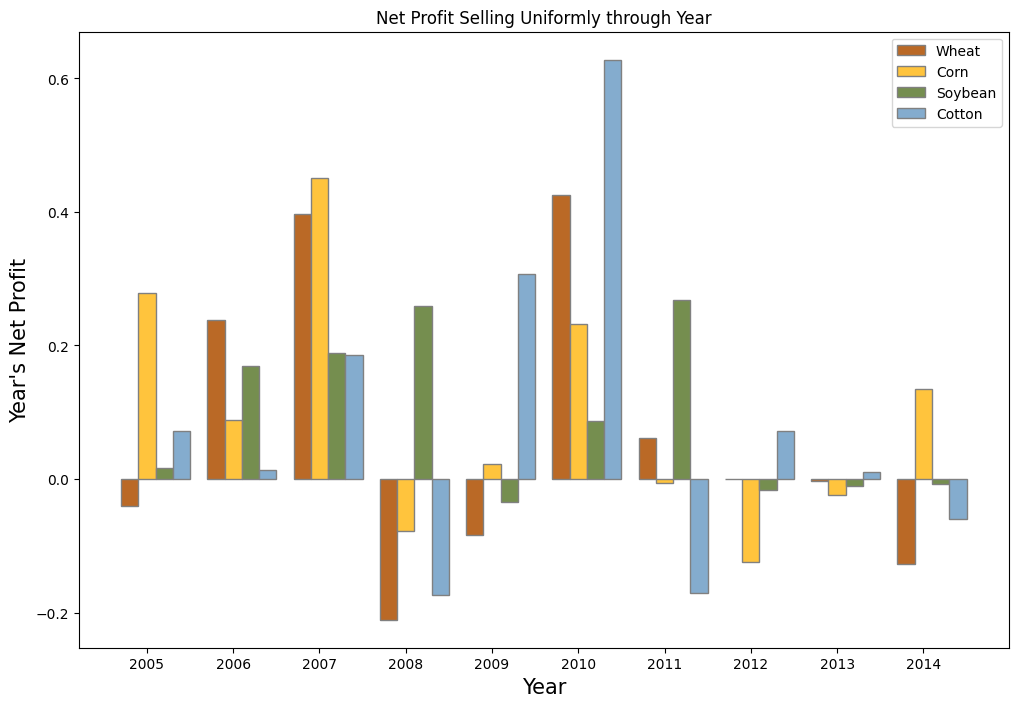

In [822]:
# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8)) 
 

# Set position of bar on X axis 
br1 = np.arange(len(wheat_uni)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 


# Make the plot
plt.bar(br1, wheat_uni, color =colour1, width = barWidth, 
        edgecolor ='grey', label ='Wheat') 
plt.bar(br2, corn_uni, color =colour2, width = barWidth, 
        edgecolor ='grey', label ='Corn') 
plt.bar(br3, soybean_uni, color =colour3, width = barWidth, 
        edgecolor ='grey', label ='Soybean') 
plt.bar(br4, cotton_uni, color =colour4, width = barWidth, 
        edgecolor ='grey', label ='Cotton') 
 
# Adding Xticks 
plt.xlabel('Year', fontsize = 15) 
plt.ylabel("Year's Net Profit", fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(wheat_uni))], 
        ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'])
plt.title("Net Profit Selling Uniformly through Year")
 
plt.legend()
plt.savefig('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/Uniform.png')
plt.show() 


In [823]:
#Best On Average Response


In [832]:
#sell over the k best months (highest average prices)
def average_best(data, start, end, low, k):
    
    averages,_, _ = Mold(data, start - 5, start -1, "Wheat")
    
    
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    data["Date"] = pd.to_datetime(data["Date"])
    df_test = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df_test["Date"]))
    months = np.ones(len(df_test["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df_test["Date"])):
        months[i] = df_test["Date"].iat[i].month
        years[i] = df_test["Date"].iat[i].year
    df_test["year"] = years
    df_test["month"] = months
  
    #matrix containing prices at start of month for secified year
    data = np.ones([end - start +1, 12])
    for i in range(end - start + 1):
        for j in range(12):
            specific = (df_test[df_test["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0]
    #print(data)
    data2 = np.zeros([end - start, 12])
    start_prices = np.zeros([end - start])
    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
    for i in range(data2.shape[0]):
        price = data2[i, 0]
        start_prices[i] = data2[i, 0]
        for j in range(data2.shape[1]):
            data2[i,j] = data2[i,j] - price

            
    #find best k average prices 
    temp = averages
    indices = np.zeros(k)
    for i in range(k):
        x = np.argmax(temp)
        indices[i] = x
        temp[x] = -10
    
    months = np.zeros([1,12])
    for i in range(k):
        months[0, int(indices[i])] = 1
    
      
    
    for i in range(data2.shape[0]):
        data2[i, :] = data2[i, :] * months
    
    return data2 * 10000 / k, np.sum(data2 * 10000 / k, axis = 1) / (start_prices*10000)

wheat_prices, wheat_av_best = average_best(wheat_df, 2005, 2015, 7, 4)
corn_prices, corn_av_best = average_best(corn_df, 2005, 2015, 11, 4)
_, soybean_av_best = average_best(soybean_df, 2005, 2015, 12, 4)
_, cotton_av_best = average_best(cotton_df, 2005, 2015, 9, 4)
print("wheat av best")
print(wheat_prices)
print("wheat uni")
print(wheat_price_uni)
print("corn")
print(corn_prices)

def excel_me(a, b, c, d, label):
    mat = np.vstack((a,b))
    mat = np.vstack((mat,c))
    mat = np.vstack((mat,d))
    data_frame = pd.DataFrame(mat)
    #data_frame.to_csv("new", index=False)
    os.makedirs('results', exist_ok=True)  
    data_frame.to_csv('results/bestk.csv')  
excel_me(wheat_av_best, corn_av_best, soybean_av_best, cotton_av_best, "BestK")

wheat av best
[[    0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.   500.  -375.
    325.   575.]
 [    0.    -0.     0.     0.     0.     0.     0.     0.  2425.  1125.
   3225.  3275.]
 [    0.     0.     0.     0.     0.     0.     0.     0. 10700.  4700.
   2375.   575.]
 [    0.    -0.    -0.    -0.    -0.    -0.    -0.    -0. -4800. -3975.
  -3100. -1250.]
 [    0.     0.    -0.    -0.    -0.    -0.    -0.    -0.   375.  -850.
    300.   450.]
 [    0.     0.     0.     0.     0.     0.     0.     0.  6650.  6925.
   7175.  6475.]
 [    0.     0.     0.    -0.     0.     0.     0.     0.  1650.  1525.
    375.   775.]
 [    0.     0.     0.     0.     0.     0.    -0.     0.  -725. -2850.
  -1175. -1350.]
 [    0.     0.    -0.     0.     0.     0.    -0.    -0.  -475.  1000.
   1050. -1175.]
 [    0.    -0.    -0.    -0.    -0.     0.     0.    -0. -1675.  -975.
  -2450. -1825.]]
wheat uni
[[    0.          -133.33333333  -466.66666667  -541.66666667
   -283.33333333  -158.

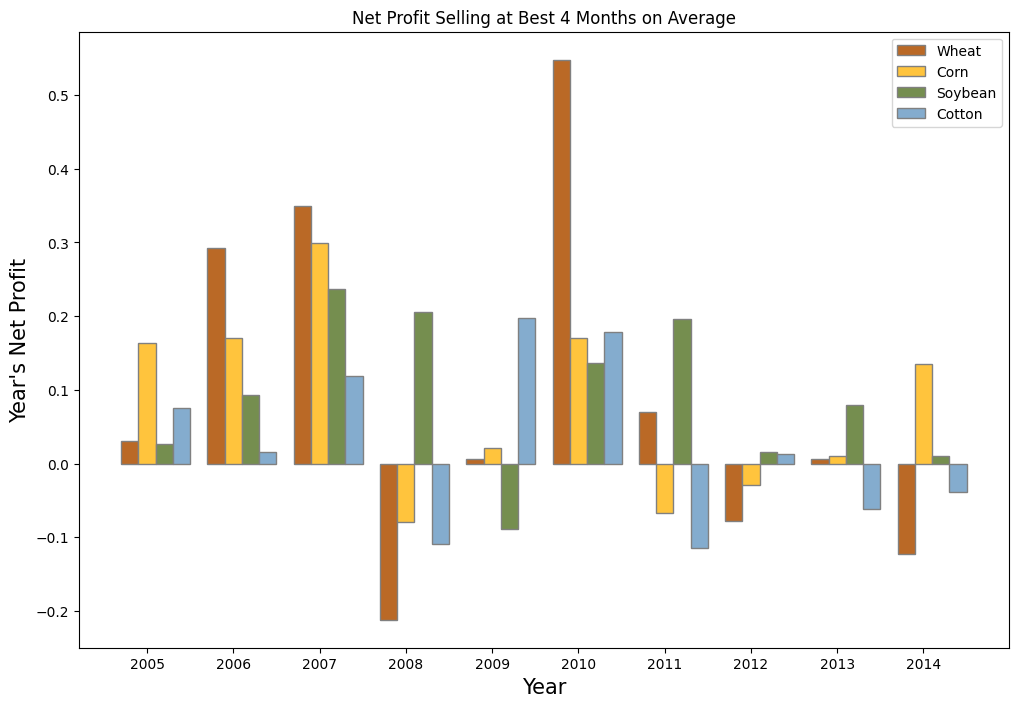

In [825]:
# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8)) 
 

# Set position of bar on X axis 
br1 = np.arange(len(wheat_av_best)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 


# Make the plot
plt.bar(br1, wheat_av_best, color =colour1, width = barWidth, 
        edgecolor ='grey', label ='Wheat') 
plt.bar(br2, corn_av_best, color =colour2, width = barWidth, 
        edgecolor ='grey', label ='Corn') 
plt.bar(br3, soybean_av_best, color =colour3, width = barWidth, 
        edgecolor ='grey', label ='Soybean') 
plt.bar(br4, cotton_av_best, color =colour4, width = barWidth, 
        edgecolor ='grey', label ='Cotton') 
 
# Adding Xticks 
plt.xlabel('Year', fontsize = 15) 
plt.ylabel("Year's Net Profit", fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(wheat_av_best))], 
        ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'])
plt.title("Net Profit Selling at Best 4 Months on Average")
 
plt.legend()
plt.savefig('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/bestk.png')
plt.show() 


In [761]:
#price is current price, n is number of months needed for trinomial model, low is when the harvest low is
def MDP_iteration(price, n, data, year, low, capacity):
    
    #set p and q values
    probs = generate_probs(n - 1, 0.25, 0.25)
    
    #generate price steps 
    _, _, av_steps = Mold(data, year -5, year -1, "unspecified")
    
    
    #generating trinomial model data
    prices = generate_price_evolution(av_steps, n -1, low, price, 1.03)   #u needs to be set, currently is 1.03, also need indicator for what month to start or atleast rename low
    
    forcasts = probs * prices 
    forcasts = np.sum(forcasts, axis = 0)
    #generate future decreciating gammas
    gamma = 0.9958     
    gammas = np.ones(n)
    
    for i in range(n):
        gammas[i] = gamma ** i
    x = cp.Variable(n)
    c = 10000 / 4
 

    constr = [x >= 0,        #no short selling
          x <= c,        #limit to how much can be sold in one time step 
          cp.sum(x) <= capacity,
             ]   #sell full amount over year. 

        
    
    objective = cp.Maximize(x @ ((gammas*forcasts)))
    problem = cp.Problem(objective, constr)
    problem.solve()
    #print(x.value.round(3))
    #print(x.value)
    #print(x.value)
    return x.value[0]
    
    
    
example_it = MDP_iteration(1, 4, wheat_df, 2010, 7, 10000)    
    

In [762]:
#function to get data from dataframe
def gather_data(data, year, low, j):
    _, data2, _ = Mold(data, year, year +1, "not specified")
    if j + low -1 >= 12: year = year + 1
    month = (j + low -1)%12 +1
    #print("month", month)
    data2 = data2[data2["year"] == year]
    data2 = data2[data2["month"] == month]   
    prices = data2["Close"].head(1).to_numpy()
    return np.mean(prices)

def iterator(start, end, data, low):
    
    actions = np.zeros([end - start, 12])
    
    for i in range(end - start):
        year = start + i
        for j in range(12):
            n = 12 - j
            
            #generate price to begin trinomial model
            #print(j)
            #print(year)
            price = gather_data(data, year, low, j)
            begin = (low + j - 1) % 12 +1
            
            capacity = 10000 - np.sum(actions[i, :])
            actions[i,j] = MDP_iteration(price, n, data, year, begin, capacity)
            
    return actions


print("wheat")
wheat_basic = iterator(2005, 2015, wheat_df, 7)
print("corn")
corn_basic = iterator(2005, 2015, corn_df, 11)      #look at bug in me
print("soybean")
soybean_basic = iterator(2005, 2015, soybean_df, 12)  
print("cotton")
cotton_basic = iterator(2005, 2015, cotton_df, 9)  



wheat
corn
soybean
cotton


In [763]:
def calculate_net_profit(data, start, end, low, actions):
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    data["Date"] = pd.to_datetime(data["Date"])
    df = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df["Date"]))
    months = np.ones(len(df["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df["Date"])):
        months[i] = df["Date"].iat[i].month
        years[i] = df["Date"].iat[i].year
    df["year"] = years
    df["month"] = months
  
    #matrix containing prices at start of month for specified year
    data = np.ones([end - start +1, 12])
    for i in range(end - start + 1):
        for j in range(12):
            specific = (df[df["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0] 
    data2 = np.zeros([end - start, 12])
    data3 = np.zeros([end - start, 12])
    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
    for i in range(data2.shape[0]):
        price = data2[i, 0]
        for j in range(data2.shape[1]):
            data3[i,j] = data2[i,j] - price
    print(data2[:, 0])
    
    return np.sum(data3 * actions, axis = 1) / (data2[:,0] *10000)

wheat_profit = calculate_net_profit(wheat_df, 2005, 2015, 7, wheat_basic) 
print(wheat_profit)
corn_profit = calculate_net_profit(corn_df, 2005, 2015, 11, corn_basic) 
soybean_profit = calculate_net_profit(soybean_df, 2005, 2015, 12, soybean_basic) 
cotton_profit = calculate_net_profit(cotton_df, 2005, 2015, 9, cotton_basic) 

[3.41 3.44 5.25 6.2  4.22 4.97 6.15 7.88 6.65 5.67]
[-0.05278592  0.35828488  0.56142858 -0.25564516 -0.02902844  0.58048289
  0.08821138 -0.03838832 -0.04849624 -0.10229276]
[1.62   3.24   3.56   3.93   3.59   5.36   6.99   7.79   4.3025 3.235 ]
[ 5.19  6.25  9.95  7.96 10.31 12.13 11.31 14.44 13.37  9.86]
[ 48.29  52.06  56.12  62.78  56.37  90.13 106.59  73.73  81.35  67.6 ]


In [833]:
def excel_me(a, b, c, d, label):
    mat = np.vstack((a,b))
    mat = np.vstack((mat,c))
    mat = np.vstack((mat,d))
    data_frame = pd.DataFrame(mat)
    #data_frame.to_csv("new", index=False)
    os.makedirs('results', exist_ok=True)  
    data_frame.to_csv('results/histmdp.csv')  
excel_me(wheat_profit, corn_profit, soybean_profit, cotton_profit, "MDPhist")

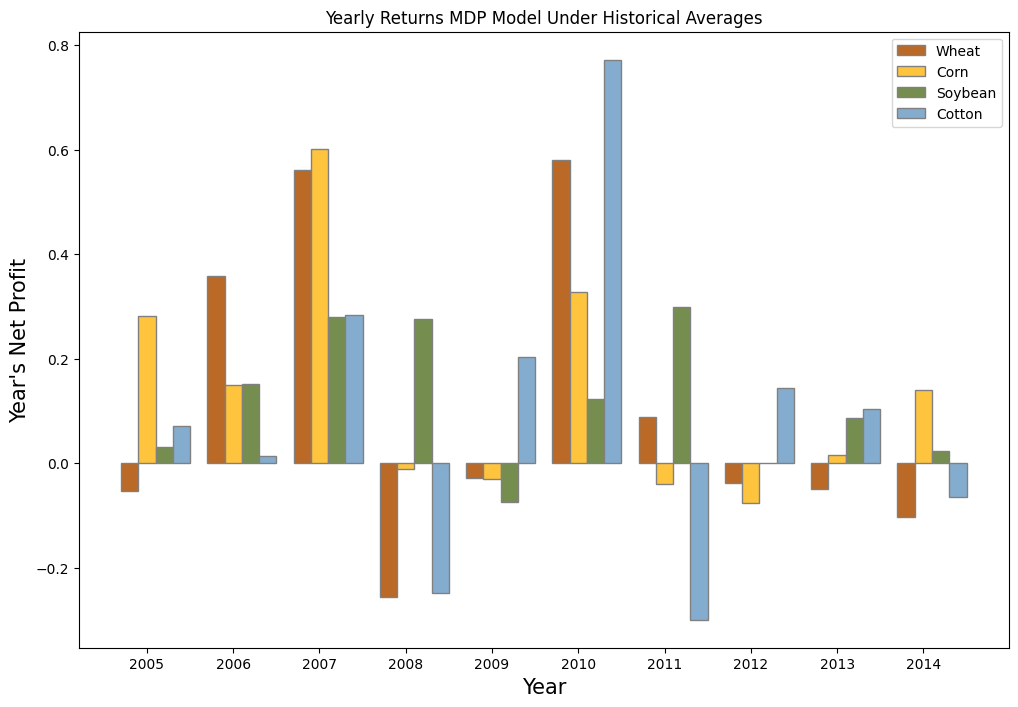

In [816]:
# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8)) 
 

# Set position of bar on X axis 
br1 = np.arange(len(wheat_profit)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, wheat_profit, color =colour1, width = barWidth, 
        edgecolor ='grey', label ='Wheat') 
plt.bar(br2, corn_profit, color =colour2, width = barWidth, 
        edgecolor ='grey', label ='Corn') 
plt.bar(br3, soybean_profit, color =colour3, width = barWidth, 
        edgecolor ='grey', label ='Soybean') 
plt.bar(br4, cotton_profit, color =colour4, width = barWidth, 
        edgecolor ='grey', label ='Cotton') 
 
# Adding Xticks 
plt.xlabel('Year', fontsize = 15) 
plt.ylabel("Year's Net Profit", fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(soybean_profit))], 
        ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'])
plt.title("Yearly Returns MDP Model Under Historical Averages")
plt.legend()
plt.savefig('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/MDPsimple.png')
plt.show() 


wheat
corn
soybean
Cotton


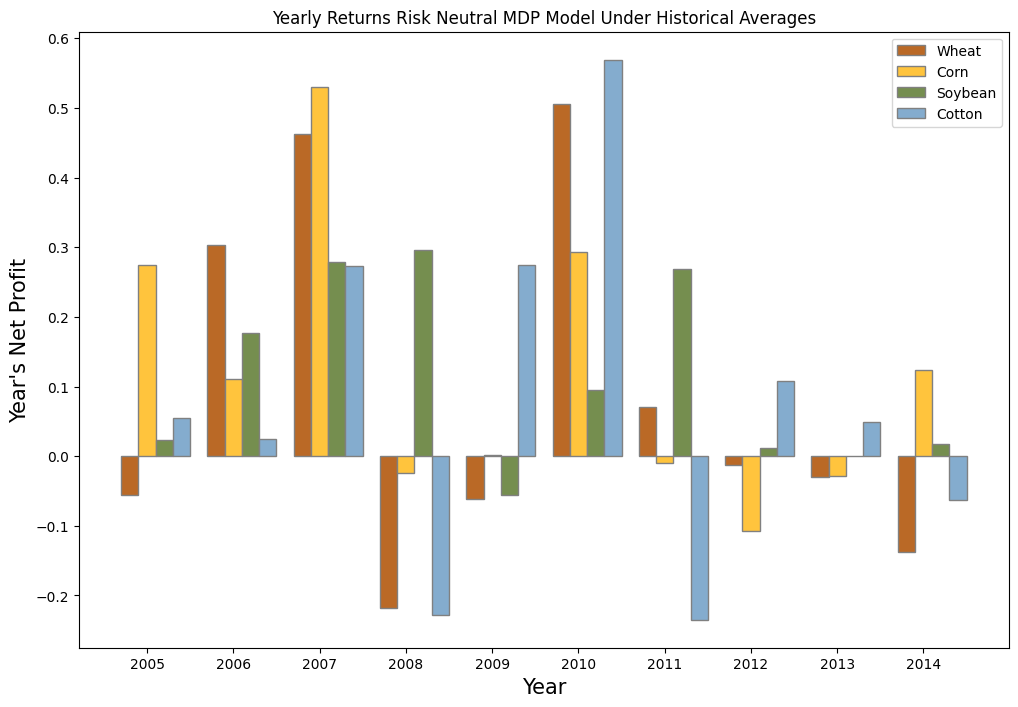

In [817]:
def MDP_iteration_neutral(price, n, data, year, low, capacity):
    
    #set p and q values
    probs = generate_probs(n - 1, 0.25, 0.25)
    
    #generate price steps 
    _, _, av_steps = Mold(data, year -5, year -1, "unspecified")
    
    
    #generating trinomial model data
    prices = generate_price_evolution(av_steps, n -1, low, price, 1.03)   #u needs to be set, currently is 1.03, also need indicator for what month to start or atleast rename low
    
    forcasts = probs * prices 
    forcasts = np.sum(forcasts, axis = 0)
    
   
    x = cp.Variable(n)
    c = 10000 / 4
 

    constr = [x >= 500,        #no short selling
          x <= c,        #limit to how much can be sold in one time step 
          cp.sum(x) <= capacity,
             ]   #sell full amount over year. 

        
    
    objective = cp.Maximize(x @ ((forcasts)))
    problem = cp.Problem(objective, constr)
    problem.solve()
    #print(x.value.round(3))
    #print(x.value)
    #print(x.value)
    return x.value[0]
    
    
def iterator_neutral(start, end, data, low):
    
    actions = np.zeros([end - start, 12])
    
    for i in range(end - start):
        year = start + i
        for j in range(12):
            n = 12 - j
            
            #generate price to begin trinomial model
            #print(j)
            #print(year)
            price = gather_data(data, year, low, j)
            begin = (low + j - 1) % 12 +1
            
            capacity = 10000 - np.sum(actions[i, :])
            actions[i,j] = MDP_iteration_neutral(price, n, data, year, begin, capacity)
            
            
            
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    data["Date"] = pd.to_datetime(data["Date"])
    df = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df["Date"]))
    months = np.ones(len(df["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df["Date"])):
        months[i] = df["Date"].iat[i].month
        years[i] = df["Date"].iat[i].year
    df["year"] = years
    df["month"] = months
  
    #matrix containing prices at start of month for specified year
    data = np.ones([end - start +1, 12])
    for i in range(end - start + 1):
        for j in range(12):
            specific = (df[df["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0]
    data2 = np.zeros([end - start, 12])
    data3 = np.zeros([end - start, 12])
    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
    for i in range(data2.shape[0]):
        price = data2[i, 0]
        for j in range(data2.shape[1]):
            data3[i,j] = data2[i,j] - price
    
    
    return np.sum(data3 * actions, axis = 1) / (data2[:,0] *10000)
            
    


print("wheat")
wheat_neutral = iterator_neutral(2005, 2015, wheat_df, 7)
print("corn")
corn_neutral = iterator_neutral(2005, 2015, corn_df, 11)     
print("soybean")
soybean_neutral = iterator_neutral(2005, 2015, soybean_df, 12)
print("Cotton")
cotton_neutral = iterator_neutral(2005, 2015, cotton_df, 9)  

# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8)) 
 

# Set position of bar on X axis 
br1 = np.arange(len(wheat_neutral)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, wheat_neutral, color =colour1, width = barWidth, 
        edgecolor ='grey', label ='Wheat') 
plt.bar(br2, corn_neutral, color =colour2, width = barWidth, 
        edgecolor ='grey', label ='Corn') 
plt.bar(br3, soybean_neutral, color =colour3, width = barWidth, 
        edgecolor ='grey', label ='Soybean')
plt.bar(br4, cotton_neutral, color =colour4, width = barWidth, 
        edgecolor ='grey', label ='Cotton')
 
# Adding Xticks 
plt.xlabel('Year', fontsize = 15) 
plt.ylabel("Year's Net Profit", fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(wheat_neutral))], 
        ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'])
plt.title("Yearly Returns Risk Neutral MDP Model Under Historical Averages")
plt.legend()
plt.savefig('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/MDPhistRN.png')
plt.show() 

In [846]:
def excel_me(a, b, c, d, label):
    mat = np.vstack((a,b))
    mat = np.vstack((mat,c))
    mat = np.vstack((mat,d))
    data_frame = pd.DataFrame(mat)
    #data_frame.to_csv("new", index=False)
    os.makedirs('folder/subfolder', exist_ok=True)  
    data_frame.to_csv('folder/subfolder/histRN.csv')  
excel_me(wheat_neutral, corn_neutral, soybean_neutral, cotton_neutral, "Uniform historic")

wheat
corn
soybean
Cotton


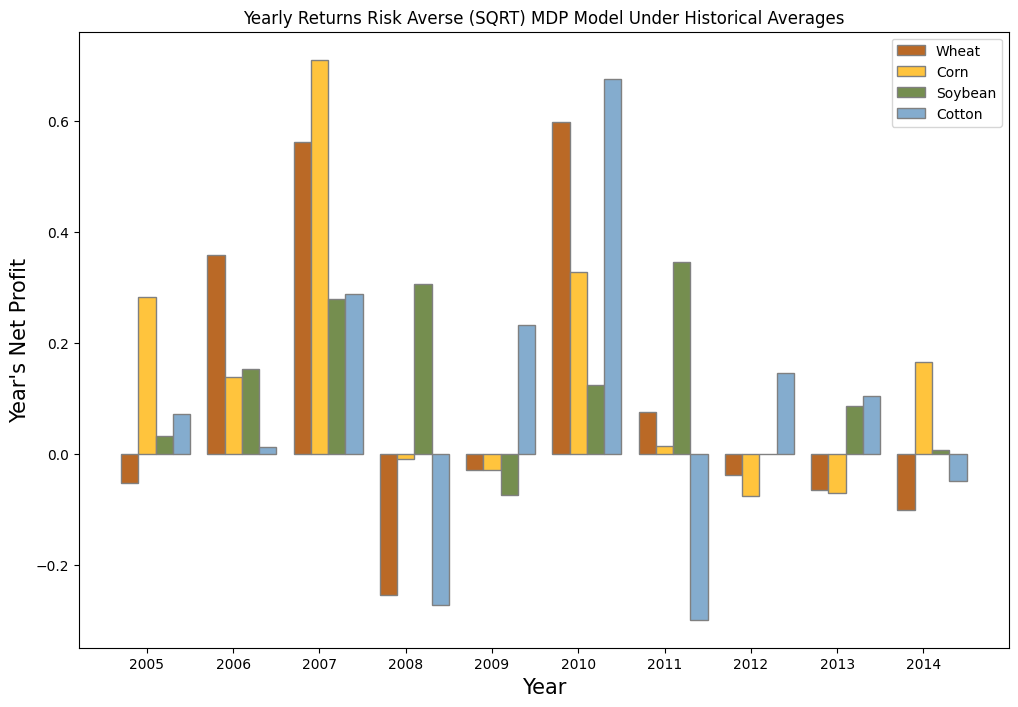

In [819]:
def MDP_iteration_sqrt(price, n, data, year, low, capacity):
    
    #set p and q values
    probs = generate_probs(n - 1, 0.25, 0.25)
    
    #generate price steps 
    _, _, av_steps = Mold(data, year -5, year -1, "unspecified")
    
    
    #generating trinomial model data
    prices = generate_price_evolution(av_steps, n -1, low, price, 1.03)   #u needs to be set, currently is 1.03, also need indicator for what month to start or atleast rename low
    prices = prices ** 0.5
    
    forcasts = probs * prices 
    forcasts = np.sum(forcasts, axis = 0)
    
   
    x = cp.Variable(n)
    c = 10000 / 4
 

    constr = [x >= 0,        #no short selling
          x <= c,        #limit to how much can be sold in one time step 
          cp.sum(x) <= capacity,
             ]   #sell full amount over year. 

        
    
    objective = cp.Maximize(x @ ((forcasts)))
    problem = cp.Problem(objective, constr)
    problem.solve()
    #print(x.value.round(3))
    #print(x.value)
    #print(x.value)
    return x.value[0]
    
    
def iterator_sqrt(start, end, data, low):
    
    actions = np.zeros([end - start, 12])
    
    for i in range(end - start):
        year = start + i
        for j in range(12):
            n = 12 - j
            
            #generate price to begin trinomial model
            #print(j)
            #print(year)
            price = gather_data(data, year, low, j)
            begin = (low + j - 1) % 12 +1
            
            capacity = 10000 - np.sum(actions[i, :])
            actions[i,j] = MDP_iteration_sqrt(price, n, data, year, begin, capacity)
            
            
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    data["Date"] = pd.to_datetime(data["Date"])
    df = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df["Date"]))
    months = np.ones(len(df["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df["Date"])):
        months[i] = df["Date"].iat[i].month
        years[i] = df["Date"].iat[i].year
    df["year"] = years
    df["month"] = months
  
    #matrix containing prices at start of month for specified year
    data = np.ones([end - start +1, 12])
    for i in range(end - start + 1):
        for j in range(12):
            specific = (df[df["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0]
    data2 = np.zeros([end - start, 12])
    data3 = np.zeros([end - start, 12])
    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
    for i in range(data2.shape[0]):
        price = data2[i, 0]
        for j in range(data2.shape[1]):
            data3[i,j] = data2[i,j] - price
    
    
    return np.sum(data3 * actions, axis = 1) / (data2[:,0] *10000)



print("wheat")
wheat_sqrt = iterator_sqrt(2005, 2015, wheat_df, 7)
print("corn")
corn_sqrt = iterator_sqrt(2005, 2015, corn_df, 11)     
print("soybean")
soybean_sqrt = iterator_sqrt(2005, 2015, soybean_df, 12)   
print("Cotton")
cotton_sqrt = iterator_sqrt(2005, 2015, cotton_df, 9)  

# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8)) 
 

# Set position of bar on X axis 
br1 = np.arange(len(wheat_neutral)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3]


# Make the plot
plt.bar(br1, wheat_sqrt, color =colour1, width = barWidth, 
        edgecolor ='grey', label ='Wheat') 
plt.bar(br2, corn_sqrt, color =colour2, width = barWidth, 
        edgecolor ='grey', label ='Corn') 
plt.bar(br3, soybean_sqrt, color =colour3, width = barWidth, 
        edgecolor ='grey', label ='Soybean') 
plt.bar(br4, cotton_sqrt, color =colour4, width = barWidth, 
        edgecolor ='grey', label ='Cotton') 
 
# Adding Xticks 
plt.xlabel('Year', fontsize = 15) 
plt.ylabel("Year's Net Profit", fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(wheat_neutral))], 
        ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'])
plt.title("Yearly Returns Risk Averse (SQRT) MDP Model Under Historical Averages")
 
plt.legend()
plt.savefig('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/MDPhistSQRT.png')
plt.show() 

In [787]:
def generate_f(df, start, end, low):
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    df["Date"] = pd.to_datetime(df["Date"])
    df_test = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df_test["Date"]))
    months = np.ones(len(df_test["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df_test["Date"])):
        months[i] = int(df_test["Date"].iat[i].month)
        years[i] = int(df_test["Date"].iat[i].year)
    df_test["year"] = years
    df_test["month"] = months
  

    #matrix containing prices at start of month for specified year
    data = np.ones([end - start +1, 12])

    for i in range(end - start + 1):
        for j in range(12):
            specific = (df_test[df_test["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0]
            
            
    data2 = np.zeros([end - start, 12])

    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
     
    avs = np.mean(data2, axis = 0)
    
    
    f = cp.Variable(12)
    
 

    constr = [cp.sum(f) == 12,
             f <= 1.3,
             f>= 0.7]
    
    
    objective = cp.Minimize(cp.sum((data2[0,:] - cp.multiply(f, avs))**2) + cp.sum((data2[1,:] - cp.multiply(f, avs))**2)+ cp.sum((data2[1,:] - cp.multiply(f, avs))**2)+ cp.sum((data2[2,:] - cp.multiply(f, avs))**2)+ cp.sum((data2[3,:] - cp.multiply(f, avs))**2))
    problem = cp.Problem(objective, constr)
    problem.solve()
    #print(f.value)
    #print("sum of log of f is ", np.sum(np.log(f.value)))
    
    
    
    return f.value
 
generate_f(corn_df, 2000, 2004, 11)

array([0.98526708, 0.99074939, 0.98653297, 0.98539225, 0.97895515,
       0.97403378, 0.97560452, 0.98168929, 1.01778755, 1.03795674,
       1.03265082, 1.05338045])

In [789]:
def calibrate_MR(df, start, end, low):
    
    
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    
    df["Date"] = pd.to_datetime(df["Date"])
    df_test = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df_test["Date"]))
    months = np.ones(len(df_test["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df_test["Date"])):
        months[i] = df_test["Date"].iat[i].month
        years[i] = df_test["Date"].iat[i].year
    df_test["year"] = years
    df_test["month"] = months
  

    #matrix containing prices at start of month for secified year
    data = np.ones([end - start +1, 12])
    for i in range(end - start + 1):
        for j in range(12):
            specific = (df_test[df_test["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0]
            
            
    data2 = np.zeros([end - start, 12])
    data3 = np.zeros([end - start, 12])
    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
    deseasonalized = np.zeros([end - start, 12])
    f = generate_f(df, start, end, low)
    for i in range(end - start):
        deseasonalized[i, :] = data2[i,:] / f
    
    
    
    
    lns = np.log(deseasonalized)
    
    points = np.linspace(0.1,5, 100)
    objective_vals = np.zeros(100)
    LRM_vals = np.zeros(100)
    
    for i in range(len(points)):
        C = points[i]
        LRM = cp.Variable()
    
 
        array = np.zeros(12)
        for j in range(12):
            array[j] = C**j
    
        
        constr = [LRM >= 0]
    
    
        objective = cp.Minimize(cp.sum((lns[0, :] - lns[0, 0] * array - cp.multiply(LRM, (1 -array)))**2) + cp.sum((lns[3, :] - lns[3, 0] * array - cp.multiply(LRM, (1 -array)))**2) + cp.sum((lns[1, :] - lns[1, 0] * array - cp.multiply(LRM, (1 -array)))**2) +cp.sum((lns[2, :] - lns[2, 0] * array - cp.multiply(LRM, (1 -array)))**2) )
        problem = cp.Problem(objective, constr)
        problem.solve()
        LRM_vals[i] = LRM.value
        objective_vals[i] = objective.value
        #print(objective.value)
    
    index = np.argmin(objective_vals)
    
    lns2 = np.zeros(lns.shape[0] * lns.shape[1] - 1)
    for i in range(lns.shape[0]):
        for j in range(lns.shape[1] - 1):
            lns2[i*12 + j] = lns[i,j+1] - lns[i,j]
    lns2[11] = lns[1, 0] - lns[0, 11]
    lns2[23] = lns[2, 0] - lns[1, 11]
    lns2[35] = lns[3, 0] - lns[2, 11]
    
    
    
    
    #returns, LRM, k, f, volatility
    #print(index)
    return LRM_vals[index], -np.log(points[index]), f, np.std(lns2)
     



LRM, k, f, vol = calibrate_MR(corn_df, 2000, 2004, 11)


In [790]:
#start is an indicator for what month the given starting price is in, e.g. if Feb, start = 2
#n is number of time periods (months) that model needs to extend to
def generate_MR_evolution(n, price, start, LRM, k, f, vol):
    start = start - 1   # for syntaxing while Jan is month 1 is index 0
    n = n+1
    height = n * 2 + 1
    matrix = np.zeros([height, n])
    #print(matrix.shape)
    #matrix[int((height -1)/2), 0] = price
    
    X_0 = np.log(price / f[start])
    
    delta_t = 1/12
    j = np.ceil(0.0184 / (k * delta_t))
    x = j * delta_t * k
    
    pu = (1/6) + 0.5 * (x**2 - x)
    pm = (2/3) - x**2 
    pd = (1/6) + 0.5 * (x**2 + x)
    
    for i in range(n):
        matrix[int((height -1)/2), i] = X_0 * np.exp(-k*i) + LRM*(1 - np.exp(-k*i)) 
    for i in range(n):
        for k in range(n):
            matrix[int((height -1)/2) + i, k] = matrix[int((height -1)/2), k] + i *vol * np.sqrt(3 * delta_t)
            matrix[int((height -1)/2) - i, k] = matrix[int((height -1)/2), k] - i * vol * np.sqrt(3 * delta_t)

    #+ 0.5 * (1 - np.exp(-2*k*i))*vol*vol/(2*k))
    #f[(start + i) %12] * np.exp(
    
   
    
    probs = generate_probs(n-1, pu, pd)
    #print(probs)
    
    for i in range(height-2):
        for k in range(n):
            if probs[i, k] == 0:
                matrix[i+1, k] = 0
            
    
    ret = np.zeros(matrix.shape)
    for i in range(height):
        for k in range(n):
            if not matrix[i, k] == 0:
                if k == 0:
                    ret[int((height -1)/2), 0] = price
                else:
                    ret[i, k] = f[(start + k) %12] * np.exp(matrix[i,k] + 0.5 * (1 - np.exp(-2*k*i))*vol*vol/(2*k))
    
    #print(ret[1:height-1, :].shape)
    return ret[1:height-1, :], probs

generate_MR_evolution(4, 1, 5, LRM, k, f, vol)

(array([[0.        , 0.        , 0.        , 0.        , 1.01559421],
        [0.        , 0.        , 0.        , 0.98920643, 1.06416541],
        [0.        , 0.        , 0.99063194, 1.03651544, 1.11505934],
        [0.        , 0.99492039, 1.03800913, 1.086087  , 1.16838729],
        [1.        , 1.04250333, 1.08765213, 1.13802934, 1.22426566],
        [0.        , 1.09236137, 1.13966932, 1.19245584, 1.28281642],
        [0.        , 0.        , 1.19417425, 1.24948529, 1.34416739],
        [0.        , 0.        , 0.        , 1.30924218, 1.40845248],
        [0.        , 0.        , 0.        , 0.        , 1.47581201]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         9.79980565e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.53876701e-03,
         1.47610731e-02],
        [0.00000000e+00, 0.00000000e+00, 3.13046413e-02, 6.25712495e-02,
         8.68517256e-02],
        [0.00000000e+00, 1.76931177e-01, 2.35764929e-01, 2.50348083e-01

In [835]:
#price is current price, n is number of months needed for trinomial model, low is when the harvest low is
def MDP_iteration_MR(price, n, data, start, capacity, LRM, k, f, vol):
    
    #set p and q values
    prices, probs = generate_MR_evolution(n-1, price, start, LRM, k, f, vol)
    
   
    forcasts = np.sum(np.multiply(prices, probs), axis = 0)
    

    
    
    #generate future decreciating gammas
    gamma = 0.9958     
    gammas = np.ones(n)
    
    for i in range(n):
        gammas[i] = gamma ** i
    x = cp.Variable(n)
    c = 10000 / 4
 

    constr = [x >= 0,        #no short selling
          x <= c,        #limit to how much can be sold in one time step 
          cp.sum(x) <= capacity,
             ]   #sell full amount over year. 

        
    
    objective = cp.Maximize(x @ ((gammas*forcasts)))
    problem = cp.Problem(objective, constr)
    problem.solve()
    #print(x.value.round(3))
    #print(x.value)
    #print(x.value)
    return x.value[0]
    
    
    
example_it = MDP_iteration(1, 4, wheat_df, 2010, 7, 10000)    
    

In [836]:
def iterator_MR(start, end, df, low):
    
    actions = np.zeros([end - start, 12])
    
    #need prices for start of each monnth in year 
    s1='-01-01'
    s2 = str(start)
    start_date = f'{s2}{s1}'
    
    s1='-12-31'
    s2 = str(end)
    end_date = f'{s2}{s1}'
    
    df["Date"] = pd.to_datetime(df["Date"])
    df_test = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    #create arrays with month and year of each 
    years = np.ones(len(df_test["Date"]))
    months = np.ones(len(df_test["Date"]))
    
    #add columns with month and year to df
    for i in range(len(df_test["Date"])):
        months[i] = df_test["Date"].iat[i].month
        years[i] = df_test["Date"].iat[i].year
    df_test["year"] = years
    df_test["month"] = months
  

    #matrix containing prices at start of month for secified year
    data = np.ones([end - start +1, 12])
    for i in range(end - start + 1):
        for j in range(12):
            specific = (df_test[df_test["year"] == i + start])
            specific = specific[specific["month"] == j+1]
            data[i,j] = specific["Close"].iat[0]
            
            
    data2 = np.zeros([end - start, 12])
    data3 = np.zeros([end - start, 12])

    for i in range(end - start):
        for j in range(12):
            index = i
            if j + low - 1 >= 12: index = index + 1
            data2[i,j] = data[index,(j + low - 1) % 12]
            data3[i,j] = data2[i,j] - data2[i,0]
    
    
    for i in range(end - start):
        year = start + i
        LRM, k, f, vol = calibrate_MR(df, year-5, year-1, low)
        for j in range(12):
            n = 12 - j
            begin = (low + j - 1) % 12 +1
            
            capacity = 10000 - np.sum(actions[i, :])
            actions[i,j] = MDP_iteration_MR(data2[i,j], n, data, begin, capacity, LRM, k, f, vol)
            
    ret = np.multiply(actions, data3)
    for i in range(ret.shape[0]):
        for j in range(ret.shape[1]):
            ret[i, j] = ret[i,j] / (data2[i, 0] * 10000)
    return np.sum(ret, axis = 1)

MR_wheat = iterator_MR(2005,2015, wheat_df, 7)
MR_corn = iterator_MR(2005,2015, corn_df, 11)
MR_soybean = iterator_MR(2005,2015, soybean_df, 12) 
MR_cotton = iterator_MR(2005,2015, soybean_df, 9) 

[ 0.03005865  0.33357559  0.28142857 -0.10806452 -0.01184834  0.34758549
  0.05569106  0.05678934 -0.01616541 -0.13492063]


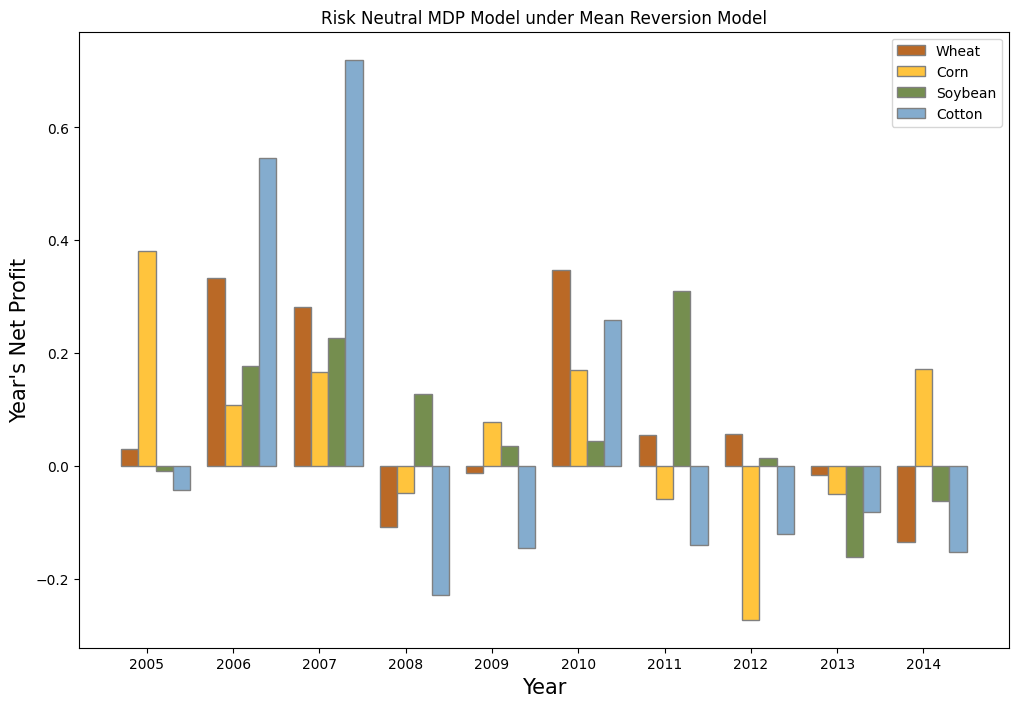

In [838]:
# set width of bar 

barWidth = 0.2
fig = plt.subplots(figsize =(12, 8)) 
print(MR_wheat)

# Set position of bar on X axis 
br1 = np.arange(len(MR_wheat)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, MR_wheat, color =colour1, width = barWidth, 
        edgecolor ='grey', label ='Wheat') 
plt.bar(br2, MR_corn, color =colour2, width = barWidth, 
        edgecolor ='grey', label ='Corn') 
plt.bar(br3, MR_soybean, color =colour3, width = barWidth, 
        edgecolor ='grey', label ='Soybean') 
plt.bar(br4, MR_cotton, color =colour4, width = barWidth, 
        edgecolor ='grey', label ='Cotton') 
 
# Adding Xticks 
plt.xlabel('Year', fontsize = 15) 
plt.ylabel("Year's Net Profit", fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(MR_wheat))], 
        ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'])
plt.title("Risk Neutral MDP Model under Mean Reversion Model")

plt.legend()
plt.savefig('C:/Users/Lachl/Documents/Princeton/Spring 2024/ORF 478/MDPmrRN.png')
plt.show() 

In [847]:
def excel_me(a, b, c, d, label):
    mat = np.vstack((a,b))
    mat = np.vstack((mat,c))
    mat = np.vstack((mat,d))
    data_frame = pd.DataFrame(mat)
    #data_frame.to_csv("new", index=False)
    os.makedirs('results', exist_ok=True)  
    data_frame.to_csv('results/RNmrMDP.csv')  
excel_me(MR_wheat, MR_corn, MR_soybean, MR_cotton, "MDPhist")